In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/yelp_dataset/final_processed_df.csv')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/yelp_dataset/business_output.csv')

In [ ]:
data.head(5)

,business_id,name_x,address_x,city_x,state_x,postal_code_x,latitude_x,longitude_x,stars_x,review_count_x,...,postal_code_y,latitude_y,longitude_y,stars,review_count_y,is_open_y,attributes_y,categories_y,hours_y,postal_code wise population
0,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746.0,32.132305,-110.999985,3.0,23,...,85746.0,32.132305,-110.999985,3.0,23.0,0.0,"{'WiFi': ""'no'"", 'BusinessParking': ""{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",46617.0
1,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746.0,32.132305,-110.999985,3.0,23,...,85746.0,32.132305,-110.999985,3.0,23.0,0.0,"{'WiFi': ""'no'"", 'BusinessParking': ""{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",46617.0
2,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746.0,32.132305,-110.999985,3.0,23,...,85746.0,32.132305,-110.999985,3.0,23.0,0.0,"{'WiFi': ""'no'"", 'BusinessParking': ""{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",46617.0
3,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746.0,32.132305,-110.999985,3.0,23,...,85746.0,32.132305,-110.999985,3.0,23.0,0.0,"{'WiFi': ""'no'"", 'BusinessParking': ""{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",46617.0
4,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746.0,32.132305,-110.999985,3.0,23,...,85746.0,32.132305,-110.999985,3.0,23.0,0.0,"{'WiFi': ""'no'"", 'BusinessParking': ""{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",46617.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478836 entries, 0 to 478835
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   business_id                  478836 non-null  object 
 1   name_x                       478836 non-null  object 
 2   address_x                    477450 non-null  object 
 3   city_x                       478836 non-null  object 
 4   state_x                      478836 non-null  object 
 5   postal_code_x                478812 non-null  float64
 6   latitude_x                   478836 non-null  float64
 7   longitude_x                  478836 non-null  float64
 8   stars_x                      478836 non-null  float64
 9   review_count_x               478836 non-null  int64  
 10  is_open_x                    478836 non-null  int64  
 11  attributes_x                 478379 non-null  object 
 12  categories_x                 478836 non-null  object 
 13 

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

# Define a function to map month to season
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['month'].apply(month_to_season)

##Sentiment Analysis

In [ ]:
# Initialize the SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

# Function to predict sentiment
def predict_sentiment(text):
    score = vader.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 1  # Positive
    elif score['compound'] <= -0.05:
        return -1  # Negative
    else:
        return 0  # Neutral

# Apply the function to the text column
data['Vader_Sentiment'] = data['text'].apply(predict_sentiment)

# Remove the 3-star reviews
data = data[data['stars_y'] != 3]

# Map sentiment for 1 and 2 star reviews to 0, and for 4 and 5 star reviews to 1
data['sentiment'] = data['stars_y'].map({1: 0, 2: 0, 4: 1, 5: 1})

# Display the modified DataFrame
print(data.head())

              business_id                   name_x  \
0  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
1  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
2  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
3  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   
4  wghnIlMb_i5U46HMBGx9ig  China Dragon Restaurant   

                         address_x  city_x state_x  postal_code_x  latitude_x  \
0  1625 W Valencia Rd, Ste 101-103  Tucson      AZ        85746.0   32.132305   
1  1625 W Valencia Rd, Ste 101-103  Tucson      AZ        85746.0   32.132305   
2  1625 W Valencia Rd, Ste 101-103  Tucson      AZ        85746.0   32.132305   
3  1625 W Valencia Rd, Ste 101-103  Tucson      AZ        85746.0   32.132305   
4  1625 W Valencia Rd, Ste 101-103  Tucson      AZ        85746.0   32.132305   

   longitude_x  stars_x  review_count_x  ...  is_open_y  \
0  -110.999985      3.0              23  ...        0.0   
1  -110.999985      3.0              23  ...        0.0   
2  -110.999

<ipython-input-9-874ed5bae2f6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['stars_y'].map({1: 0, 2: 0, 4: 1, 5: 1})


In [ ]:
# Calculate average stars, review count and sentiment at the business level
aggregated_features = data.groupby('business_id').agg({
    'stars_y': 'mean',
    'review_count_x': 'sum',  # Assuming you want the total review count for the business across all entries
    'sentiment': 'mean',
    # Any other aggregation you find necessary
}).reset_index()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer()
data['processed_text'] = data['processed_text'].fillna('')
dtm = count_vectorizer.fit_transform(data['processed_text'])

In [ ]:
# Initialize LDA model
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, random_state=42)
# Continuing from the Latent Dirichlet Allocation (LDA) application to the document-term matrix (dtm)
lda_model.fit(dtm)

LatentDirichletAllocation(random_state=42)

In [ ]:
topic_results = lda_model.transform(dtm)  # Get the distribution of topics for each document

# Add dominant topic for each review to the original dataframe
data['dominant_topic'] = topic_results.argmax(axis=1)

# Calculate topic proportions for each business
topic_proportions = data.pivot_table(index='business_id', columns='dominant_topic', aggfunc='size', fill_value=0)
topic_proportions = topic_proportions.div(topic_proportions.sum(axis=1), axis=0)  # Normalize to get proportions

# Add dominant topic for each business based on the highest proportion
dominant_topic_per_business = topic_proportions.idxmax(axis=1).to_frame(name='dominant_business_topic')

In [ ]:
# Step 2: Calculating Topic Sentiment Scores

# Assuming sentiment scores are already in df['sentiment']

# Calculate average sentiment score for each topic within each business
topic_sentiment_scores = data.groupby(['business_id', 'dominant_topic'])['sentiment'].mean().unstack(fill_value=0)

In [ ]:
# Step 3: Deriving Temporal Trends

# Calculate yearly average rating for each business
yearly_avg_rating = data.groupby(['business_id', 'year'])['stars'].mean().unstack(fill_value=0)

# Calculate yearly average sentiment for each business
yearly_avg_sentiment = data.groupby(['business_id', 'year'])['sentiment'].mean().unstack(fill_value=0)

In [ ]:
# Step 4: Preparing the Final Dataset for Regression Analysis

# Merge all the new feature frames into the aggregated_features dataframe
# Ensure that 'business_id' is the index or a column in all DataFrames for proper merging
final_features = aggregated_features.join(topic_proportions, on='business_id')
final_features = final_features.join(dominant_topic_per_business, on='business_id')
final_features = final_features.join(topic_sentiment_scores, on='business_id', rsuffix='_sentiment')
final_features = final_features.join(yearly_avg_rating, on='business_id', rsuffix='_yearly_rating')
final_features = final_features.join(yearly_avg_sentiment, on='business_id', rsuffix='_yearly_sentiment')

# Normalize or scale the final_features as needed before regression analysis
scaler = StandardScaler()
scaled_final_features = scaler.fit_transform(final_features.drop(['business_id'], axis=1))

In [ ]:
final_features

,business_id,stars_y,review_count_x,sentiment,0,1,2,3,4,5,...,2013_yearly_sentiment,2014_yearly_sentiment,2015_yearly_sentiment,2016_yearly_sentiment,2017_yearly_sentiment,2018_yearly_sentiment,2019_yearly_sentiment,2020_yearly_sentiment,2021_yearly_sentiment,2022_yearly_sentiment
0,--onnLZrsCazmcy2P_7fcw,3.000000,35,0.600000,0.000000,0.000000,0.000000,0.200000,0.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,-0G_6-KFGpCpxTUlVXCMYQ,3.712000,18500,0.720000,0.008000,0.024000,0.464000,0.056000,0.120000,0.064000,...,1.000000,0.716981,0.615385,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,-1MhPXk1FglglUAmuPLIGg,4.020408,10486,0.857143,0.000000,0.000000,0.000000,0.071429,0.132653,0.030612,...,0.800000,0.875000,1.000000,0.875000,0.714286,1.00000,0.750000,0.666667,0.818182,0.000000
3,-1iLbEf1NwY-OJp5Hg-3Sg,3.166667,156,0.583333,0.000000,0.083333,0.000000,0.000000,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.666667,0.50000,1.000000,0.000000,0.000000,0.000000
4,-1w9JMktu9oWTXwNqtZQoA,3.882353,272,0.764706,0.000000,0.000000,0.411765,0.000000,0.000000,0.117647,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.714286,0.666667,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3831,zu4p6IZLSVn2Noto-vcwzw,3.695652,23322,0.768116,0.000000,0.000000,0.007246,0.057971,0.115942,0.514493,...,0.733333,0.818182,0.782609,0.562500,0.700000,0.75000,1.000000,0.000000,0.000000,0.000000
3832,zu8Q3zYfgJaOn96LbPt_Hw,2.125000,48,0.250000,0.375000,0.000000,0.000000,0.125000,0.125000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3833,zuolhAJZMexj75-5IZ8bQg,3.294118,323,0.588235,0.058824,0.000000,0.058824,0.294118,0.352941,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.333333,0.50000,0.000000,1.000000,0.000000,0.000000
3834,zwrgCMuZyFX46mL3piDyjg,4.319803,700806,0.901599,0.072571,0.003690,0.006150,0.159902,0.102091,0.130381,...,0.932203,0.911765,0.960526,0.818182,0.931507,0.92233,0.834951,0.957447,0.861538,0.666667


In [ ]:

# Print the columns of the dataframe
print(final_features.columns)

# Get the info of the dataframe, including the data types and number of non-null values
print(final_features.info())

# Get statistical insights about the dataframe
print(final_features.describe())

Index(['business_id', 'stars_y', 'review_count_x', 'sentiment', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', 'dominant_business_topic',
       '0_sentiment', '1_sentiment', '2_sentiment', '3_sentiment',
       '4_sentiment', '5_sentiment', '6_sentiment', '7_sentiment',
       '8_sentiment', '9_sentiment', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', '2020', '2021', '2022', '2005_yearly_sentiment',
       '2006_yearly_sentiment', '2007_yearly_sentiment',
       '2008_yearly_sentiment', '2009_yearly_sentiment',
       '2010_yearly_sentiment', '2011_yearly_sentiment',
       '2012_yearly_sentiment', '2013_yearly_sentiment',
       '2014_yearly_sentiment', '2015_yearly_sentiment',
       '2016_yearly_sentiment', '2017_yearly_sentiment',
       '2018_yearly_sentiment', '2019_yearly_sentiment',
       '2020_yearly_sentiment', '2021_yearly_sentiment',
       '2022_yearly_sentiment'],
      dty

In [ ]:
result_df = pd.merge(final_features, df2[['business_id', 'is_open']], on='business_id', how='left')

In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3836 entries, 0 to 3835
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   business_id              3836 non-null   object 
 1   stars_y                  3836 non-null   float64
 2   review_count_x           3836 non-null   int64  
 3   sentiment                3836 non-null   float64
 4   0                        3836 non-null   float64
 5   1                        3836 non-null   float64
 6   2                        3836 non-null   float64
 7   3                        3836 non-null   float64
 8   4                        3836 non-null   float64
 9   5                        3836 non-null   float64
 10  6                        3836 non-null   float64
 11  7                        3836 non-null   float64
 12  8                        3836 non-null   float64
 13  9                        3836 non-null   float64
 14  dominant_business_topic 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
result_df1 = result_df.drop(['business_id'], axis=1)

In [ ]:
# Prepare data for logistic regression
X = result_df1.drop('is_open', axis=1)
y = result_df1['is_open']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median', 'most_frequent', etc.

# Fit and transform X_train
X_train_imputed = imputer.fit_transform(X_train)

# Transform X_test (using the same imputer)
X_test_imputed = imputer.transform(X_test)

Accuracy: 0.9166666666666666

Confusion Matrix:
 [[233  37]
 [ 27 471]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       270
           1       0.93      0.95      0.94       498

    accuracy                           0.92       768
   macro avg       0.91      0.90      0.91       768
weighted avg       0.92      0.92      0.92       768

AUC-ROC Score: 0.9530343596608657


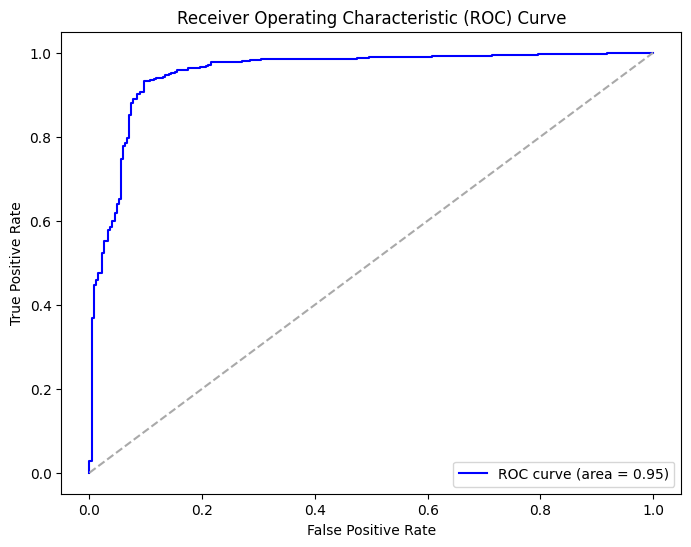

In [ ]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
model.fit(X_train_imputed, y_train)

# Predictions
y_pred = model.predict(X_test_imputed)
y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]  # Get probabilities for the positive class

# Basic Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_roc}")

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# @title Default title text
coefficients = model.coef_[0]  # model.coef_ is an array of shape (1, n_features) for binary classification

# If X_train is a DataFrame, you can make this more interpretable by attaching the feature names
feature_names = X_train.columns
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

                          Coefficient
2021                     8.369525e-01
2020                     4.838557e-01
2022                     3.745606e-01
2019                     2.777540e-01
2021_yearly_sentiment    1.457342e-01
2018                     1.327380e-01
2020_yearly_sentiment    8.107787e-02
2022_yearly_sentiment    6.761131e-02
2017                     6.703071e-02
2019_yearly_sentiment    4.186503e-02
8                        2.986137e-02
2016                     1.854420e-02
2018_yearly_sentiment    1.543435e-02
2012_yearly_sentiment    7.124880e-03
2012                     6.946720e-03
2017_yearly_sentiment    6.246884e-03
2016_yearly_sentiment    4.901949e-03
2010_yearly_sentiment    2.512023e-03
2013_yearly_sentiment    1.243553e-03
2011_yearly_sentiment    7.140591e-04
2005_yearly_sentiment    5.578463e-04
review_count_x          -3.246498e-07
9                       -6.033851e-04
2006_yearly_sentiment   -1.072369e-03
2005                    -2.330974e-03
5           

In [ ]:
file_path = '/content/drive/My Drive/yelp_dataset/final_features_df.csv'
result_df.to_csv(file_path, index=False)

In [ ]:
!pip install jupyter
!pip install nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00
[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Logistic_Regression_509Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configurati

In [ ]:
!jupyter nbconvert "/content/drive/MyDrive/Colab Notebooks/Logistic_Regression_509Project.ipynb" --to html

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Logistic_Regression_509Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    E